<img src="https://github.com/rjpost20/Anomalous-Bank-Transactions-Detection-Project/blob/main/data/AdobeStock_319163865.jpeg?raw=true">
Image by <a href="https://stock.adobe.com/contributor/200768506/andsus?load_type=author&prev_url=detail" >AndSus</a> on Adobe Stock

# Phase 5 Project: *Detecting Anomalous Financial Transactions*

## Notebook 3: Modeling, Analysis and Results

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 25th, 2022<br>
Instructor: Joseph Mata

<br>

# Imports and Reading in Data

### Google colab compatibility downloads

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz 
!tar xf spark-3.3.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
!pip install pyspark==3.3.0
!pip install -q findspark
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2,311 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,369 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:13 http://ppa.launchp

In [55]:
# Connect to Google drive
from google.colab import drive, files
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import numpy as np
import pandas as pd
from itertools import chain

# from pyspark.ml.feature import StringIndexer, OneHotEncoder, 
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, TrainValidationSplitModel

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Import helper functions
helper_functions = files.upload()
from helper_functions import set_weight_col

Saving helper_functions.py to helper_functions.py


In [5]:
# Check Colab GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


In [6]:
# Check Colab RAM info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [7]:
# Set text to wrap in Google colab notebook
def set_css():
    display(HTML("""
    <style>
      pre {
          white-space: pre-wrap;
      }
    </style>
    """))
get_ipython().events.register('pre_run_cell', set_css)

In [8]:
# Initialize Spark Session
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config("spark.ui.port", "4050")\
        .config("spark.driver.memory", "15g")\
        .getOrCreate()

spark

## Read in Data

In [9]:
# Read in weighted_df and resampled_df (training data) and test_df_preprocessed (testing data) data csv files as Spark DataFrames
train_df_preprocessed = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/train_df_preprocessed.csv', header=True, inferSchema=True)
test_df_preprocessed = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/test_df_preprocessed.csv', header=True, inferSchema=True)

<br>

## Add `Weight` column to dataframe

As we've seen, the training dataset is extremely imbalanced in regards to target class distribution. In order to improve modeling performance, we'll add a new column `Weight` to `train_df_preprocessed` specifying the weights to use, which we pass in to PySpark models in the `weightCol` parameter. We'll create the new `Weight` column using the `set_weight_col` function in `helper_functions`.

Our initial `Weight` column will specify equal weights across all observations, which is the default in PySpark.

In [10]:
print(set_weight_col.__doc__)


    Calculates and creates a column of class weights 
    in a PySpark dataframe with an imbalanced binary 
    target class distribution.

    Parameters
    ----------
    df : Spark `DataFrame`
        The Spark `DataFrame` to assign the 
        `ClassWeight` column to
    label_col : Spark `Column`
        Label column name
    neg_class_weight : '`float` or 'balanced'
        New class weight to assign to negative class 
        (`0`) in weight column. If 'balanced', assigned 
        class weights will be equal to 1 - proportion of 
        class in dataframe. If `float`, negative class 
        will be assigned `neg_class_weight` and positive 
        class weights remain at 1.0.
    


In [11]:
train_df_preprocessed = set_weight_col(train_df_preprocessed, label_col='Label', neg_class_weight=1.0)

In [12]:
# Preview Weight column
cols_to_show = ['MessageId', 'Label', 'Weight']
train_df_preprocessed.select(cols_to_show).where(train_df_preprocessed.Label == 0).show(1, truncate=False, vertical=True)
train_df_preprocessed.select(cols_to_show).where(train_df_preprocessed.Label == 1).show(1, truncate=False, vertical=True)

-RECORD 0---------------
 MessageId | TRFXV1O7R2 
 Label     | 0          
 Weight    | 1.0        
only showing top 1 row

-RECORD 0---------------
 MessageId | TR14I40JIT 
 Label     | 1          
 Weight    | 1.0        
only showing top 1 row



In [13]:
# Print shape of dataframes
print(f"train_df_preprocessed:  {train_df_preprocessed.count():,} Rows, {len(train_df_preprocessed.columns)} Columns")
print(f"test_df_preprocessed:  {test_df_preprocessed.count():,} Rows, {len(test_df_preprocessed.columns)} Columns")

train_df_preprocessed:  4,691,725 Rows, 15 Columns
test_df_preprocessed:  705,108 Rows, 14 Columns


In [14]:
# Print schema of training dataframe
print('train_df_preprocessed:')
train_df_preprocessed.printSchema()

train_df_preprocessed:
root
 |-- MessageId: string (nullable = true)
 |-- Label: integer (nullable = true)
 |-- InstructedAmountUSD: integer (nullable = true)
 |-- IntermediaryTransactions: integer (nullable = true)
 |-- Flagged: integer (nullable = true)
 |-- OrderingCountryFreq: integer (nullable = true)
 |-- BeneficiaryCountryFreq: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- SenderHourFreq: integer (nullable = true)
 |-- SenderCurrencyFreq: integer (nullable = true)
 |-- SenderCurrencyAmtAvg: integer (nullable = true)
 |-- SenderFreq: integer (nullable = true)
 |-- ReceiverFreq: integer (nullable = true)
 |-- SenderReceiverFreq: integer (nullable = true)
 |-- Weight: double (nullable = true)



In [15]:
# Print schema of test dataframe
print('test_df_preprocessed:')
test_df_preprocessed.printSchema()

test_df_preprocessed:
root
 |-- MessageId: string (nullable = true)
 |-- Label: integer (nullable = true)
 |-- InstructedAmountUSD: integer (nullable = true)
 |-- IntermediaryTransactions: integer (nullable = true)
 |-- Flagged: integer (nullable = true)
 |-- OrderingCountryFreq: integer (nullable = true)
 |-- BeneficiaryCountryFreq: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- SenderHourFreq: integer (nullable = true)
 |-- SenderCurrencyFreq: integer (nullable = true)
 |-- SenderCurrencyAmtAvg: integer (nullable = true)
 |-- SenderFreq: integer (nullable = true)
 |-- ReceiverFreq: integer (nullable = true)
 |-- SenderReceiverFreq: integer (nullable = true)



In [16]:
# Drop 'MessageId' individual transaction identifier column - will not be used in modeling
train_df_preprocessed = train_df_preprocessed.drop('MessageId')
test_df_preprocessed = test_df_preprocessed.drop('MessageId')

# Rename target variable 'Label' column to more descriptive 'Anomalous'
train_df_preprocessed = train_df_preprocessed.withColumnRenamed('Label', 'Anomalous')
test_df_preprocessed = test_df_preprocessed.withColumnRenamed('Label', 'Anomalous')

In [17]:
# Display first row of train_df_preprocessed dataframe
train_df_preprocessed.show(n=1, truncate=False, vertical=True)

-RECORD 0---------------------------
 Anomalous                | 0       
 InstructedAmountUSD      | 519149  
 IntermediaryTransactions | 0       
 Flagged                  | 0       
 OrderingCountryFreq      | 73733   
 BeneficiaryCountryFreq   | 40984   
 Hour                     | 8       
 SenderHourFreq           | 47559   
 SenderCurrencyFreq       | 73733   
 SenderCurrencyAmtAvg     | 1906631 
 SenderFreq               | 73733   
 ReceiverFreq             | 41012   
 SenderReceiverFreq       | 40984   
 Weight                   | 1.0     
only showing top 1 row



In [18]:
# Display first row of test_df_preprocessed dataframe
test_df_preprocessed.show(n=1, truncate=False, vertical=True)

-RECORD 0---------------------------
 Anomalous                | 0       
 InstructedAmountUSD      | 653958  
 IntermediaryTransactions | 0       
 Flagged                  | 0       
 OrderingCountryFreq      | 73733   
 BeneficiaryCountryFreq   | 40984   
 Hour                     | 8       
 SenderHourFreq           | 47559   
 SenderCurrencyFreq       | 73733   
 SenderCurrencyAmtAvg     | 1906631 
 SenderFreq               | 73733   
 ReceiverFreq             | 41012   
 SenderReceiverFreq       | 40984   
only showing top 1 row



In [35]:
# Display value counts for 'Anomalous' column (classification target)
class_counts = train_df_preprocessed.groupBy('Anomalous').count().withColumn('percent', F.col('count')/train_df_preprocessed.count())

class_counts.show(truncate=False)

+---------+-------+---------------------+
|Anomalous|count  |percent              |
+---------+-------+---------------------+
|1        |4900   |0.0010443919880214632|
|0        |4686825|0.9989556080119786   |
+---------+-------+---------------------+



<br>

# Create Pipeline to Preprocess and Model Data

### Index string columns with StringIndexer

In [ ]:
# stages = []

# categoricalCols = [item[0] for item in train_df_resampled.dtypes if item[1].startswith('string')]

# indexers = []

# for col in categoricalCols:
#     indexer = StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep')
#     indexers.append(indexer)
    
# indexed_features = []
# for si in indexers:
#     indexed_features.append(si.getOutputCol())
    
# print(f"Indexed nominal categorical features: \n{indexed_features}")

### Create a OneHotEncoder to encode the indexed string features

In [ ]:
# encoder = OneHotEncoder(inputCols=indexed_features, 
#                         outputCols=[col + '_ohe' for col in indexed_features], 
#                         dropLast=True)

# print(f"One hot encoded nominal categorical features: {len(encoder.getOutputCols())}\n{encoder.getOutputCols()}")

### Compile numeric features, not including target or class weight columns

In [19]:
numeric_features = []
for column in train_df_preprocessed.columns:
    if column != 'Anomalous' and column != 'Weight':
        numeric_features.append(column)

# Confirm equal column counts
assert len(train_df_preprocessed.drop('Anomalous', 'Weight').columns) == len(numeric_features)
print(f"Numeric features: {len(numeric_features)}\n{numeric_features}")

Numeric features: 12
['InstructedAmountUSD', 'IntermediaryTransactions', 'Flagged', 'OrderingCountryFreq', 'BeneficiaryCountryFreq', 'Hour', 'SenderHourFreq', 'SenderCurrencyFreq', 'SenderCurrencyAmtAvg', 'SenderFreq', 'ReceiverFreq', 'SenderReceiverFreq']


In [20]:
# Print names of final features going into the model
features = numeric_features
print(f"Final features: {len(features)}\n{features}")

Final features: 12
['InstructedAmountUSD', 'IntermediaryTransactions', 'Flagged', 'OrderingCountryFreq', 'BeneficiaryCountryFreq', 'Hour', 'SenderHourFreq', 'SenderCurrencyFreq', 'SenderCurrencyAmtAvg', 'SenderFreq', 'ReceiverFreq', 'SenderReceiverFreq']


### Create a VectorAssembler to combine all features

In [21]:
assembler = VectorAssembler(inputCols=features, outputCol='vectorized_features')

# Assemble a list of stages that includes the vector assembler and standard scaler
scaler = StandardScaler(inputCol='vectorized_features', outputCol='scaled_features')

stages = [assembler, scaler]
print("Stages:", stages)

Stages: [VectorAssembler_ef42969d5727, StandardScaler_f541b8953bb5]


### Preview modeling pipeline

In [22]:
pipeline = Pipeline(stages=stages)

pipeline_model = pipeline.fit(train_df_preprocessed)

pipeline_df = pipeline_model.transform(train_df_preprocessed)

In [23]:
# Display first row of train_df_preprocessed after running through pipeline
pipeline_df.show(1, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Anomalous                | 0                                                                                                                                                                                                                  
 InstructedAmountUSD      | 519149                                                                                                                                                                                                             
 IntermediaryTransactions | 0                                                                                                                                                                                                                  
 Flagged                  | 0           

In [24]:
pipeline_test = pipeline.fit(test_df_preprocessed)

pipeline_df_test = pipeline_model.transform(test_df_preprocessed)

pipeline.fit(test_df_preprocessed).transform(test_df_preprocessed).head()['scaled_features'].size

12

In [25]:
# Display first row of test_df_preprocessed after running through pipeline
pipeline_df_test.show(1, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Anomalous                | 0                                                                                                                                                                                                                  
 InstructedAmountUSD      | 653958                                                                                                                                                                                                             
 IntermediaryTransactions | 0                                                                                                                                                                                                                  
 Flagged                  | 0           

<br>

In [ ]:
print(vars(BinaryClassificationEvaluator.metricName))

In [71]:
def grid_search(stages_with_classifier, train_df, model_grid, parallelism, seed=42):
    pipeline = Pipeline(stages=stages_with_classifier)
    # Define evaluator
    evaluator = BinaryClassificationEvaluator(labelCol='Anomalous', 
                                              metricName="areaUnderPR")
    # Define train/validation split with pipeline above
    tvs = TrainValidationSplit(estimator=pipeline, 
                               estimatorParamMaps=model_grid, 
                               evaluator=evaluator, 
                               parallelism=parallelism, 
                               seed=seed)
    # Fit the tvs model
    tvs_model = tvs.fit(train_df)
    # Store best model parameters in variable
    best_model_parameters = model_grid[np.argmax(tvs_model.validationMetrics)]

    # Print best model parameters
    print(best_model_parameters)
    # Return best model
    return tvs_model

In [74]:
def score_model(model, train_df, test_df, preprocessing_stages=stages):
    # Define evaluator_1 for areaUnderPR (curve)
    evaluator_1 = BinaryClassificationEvaluator(labelCol='Anomalous', 
                                                metricName="areaUnderPR")
    
    # Define evaluator_2 for accuracy, precision, recall, and f1 scores
    evaluator_2 = MulticlassClassificationEvaluator(labelCol='Anomalous')
    # Store train and test dataframes in variables
    train_results = model.transform(train_df)
    test_results = model.transform(test_df)
    # Compute accuracy scores on train and test data
    train_acc = evaluator_2.evaluate(train_results, {evaluator_2.metricName: 'accuracy'})
    test_acc = evaluator_2.evaluate(test_results, {evaluator_2.metricName: 'accuracy'})
    # Compute AUPRC scores on train and test data
    train_auprc = evaluator_1.evaluate(train_results)
    test_auprc = evaluator_1.evaluate(test_results)
    # Compute precision scores on test data
    test_precision_0 = evaluator_2.evaluate(test_results, 
                                            {evaluator_2.metricName: 'precisionByLabel', 
                                             evaluator_2.metricLabel: 0})
    test_precision_1 = evaluator_2.evaluate(test_results, 
                                            {evaluator_2.metricName: 'precisionByLabel', 
                                             evaluator_2.metricLabel: 1})
    # Compute recall scores on test data
    test_recall_0 = evaluator_2.evaluate(test_results, 
                                         {evaluator_2.metricName: 'recallByLabel', 
                                          evaluator_2.metricLabel: 0})
    test_recall_1 = evaluator_2.evaluate(test_results, 
                                         {evaluator_2.metricName: 'recallByLabel', 
                                          evaluator_2.metricLabel: 1})

    print(model, '\n')
    print(f"Training set accuracy: {round(train_acc, 3)}", end='\t')
    print(f"Test set accuracy: {round(test_acc, 3)}")
    print('-'*60)
    print(f"Training set AUPRC: {round(train_auprc, 3)}", end='\t')
    print(f"Test set AUPRC: {round(test_auprc, 3)}")
    print('-'*60)
    print("Test set precision")
    print(f"Non-anomalous {round(test_precision_0, 3)}", end='\t')
    print(f"Anomalous: {round(test_precision_1, 3)}")
    print('-'*60)
    print("Test set recall")
    print(f"Non-anomalous: {round(test_recall_0, 3)}", end='\t')
    print(f"Anomalous: {round(test_recall_1, 3)}")

In [195]:
def plot_confusion_matrix(model, test_df, preprocessing_stages=stages):
    # Convert Anomalous column to array
    y_true = np.array(test_df.select('Anomalous').collect())
    # Calculate predictions and convert prediction column to array
    y_predicted = np.array(model.transform(test_df).select('prediction').collect())

    
    fig, ax1 = plt.subplots(figsize=(18, 7))

    # Plot confusion matrix
    labels = ['0: Non-anomalous', '1: Anomalous']
    cm = confusion_matrix(y_true, y_predicted)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_disp.plot(cmap='Reds', ax=ax1, values_format='')
    ax1.set_title('Confusion Matrix', size=15, fontweight='bold')
    ax1.set_xlabel(ax1.get_xlabel(), size=13)
    ax1.set_ylabel(ax1.get_ylabel(), size=13)
    ax1.tick_params(axis='both', which='both', labelsize=12)
    for labels in cm_disp.text_.ravel():
        labels.set_fontsize(12)
    ax1.grid(False)

    # Plot precision-recall curve
    # y_true = np.array(test_df.select('Anomalous').collect()).reshape(-1)
    # y_scores = np.array(model.transform(test_df).select('prediction').collect()).reshape(-1)
    # pr_disp = PrecisionRecallDisplay.from_predictions(y_true, y_scores, ax=ax2)
    # pr_disp.plot(ax=ax2)

<br>

# Baseline Model: Basic Logistic Regression

For our first and baseline model, we'll fit a simple un-tuned logistic regression model.

In [62]:
# Set classifier parameters
lr_0 = LogisticRegression(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight',
    standardization=False)

In [63]:
# Assign to pipeline
lr_0_pipeline = Pipeline(stages=stages + [lr_0])

# Fit to training data
if not os.path.isdir(drive_path + 'lr_0_model'):
    lr_0_model = lr_0_pipeline.fit(train_df_preprocessed)

In [68]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'lr_0_model'):
    lr_0_model.save(drive_path + 'lr_0_model')
else:
    lr_0_model = PipelineModel.load(drive_path + 'lr_0_model')

In [66]:
# Print model scores
score_model(model=lr_0_model, train_df=train_df_preprocessed, test_df=test_df_preprocessed)

PipelineModel_7b8a559d87c5 

Training set accuracy: 0.999	Test set accuracy: 0.967
------------------------------------------------------------
Training set AUPRC: 0.224	Test set AUPRC: 0.069
------------------------------------------------------------
Test set precision
Non-anomalous 0.999	Anomalous: 0.01
------------------------------------------------------------
Test set recall
Non-anomalous: 0.967	Anomalous: 0.294


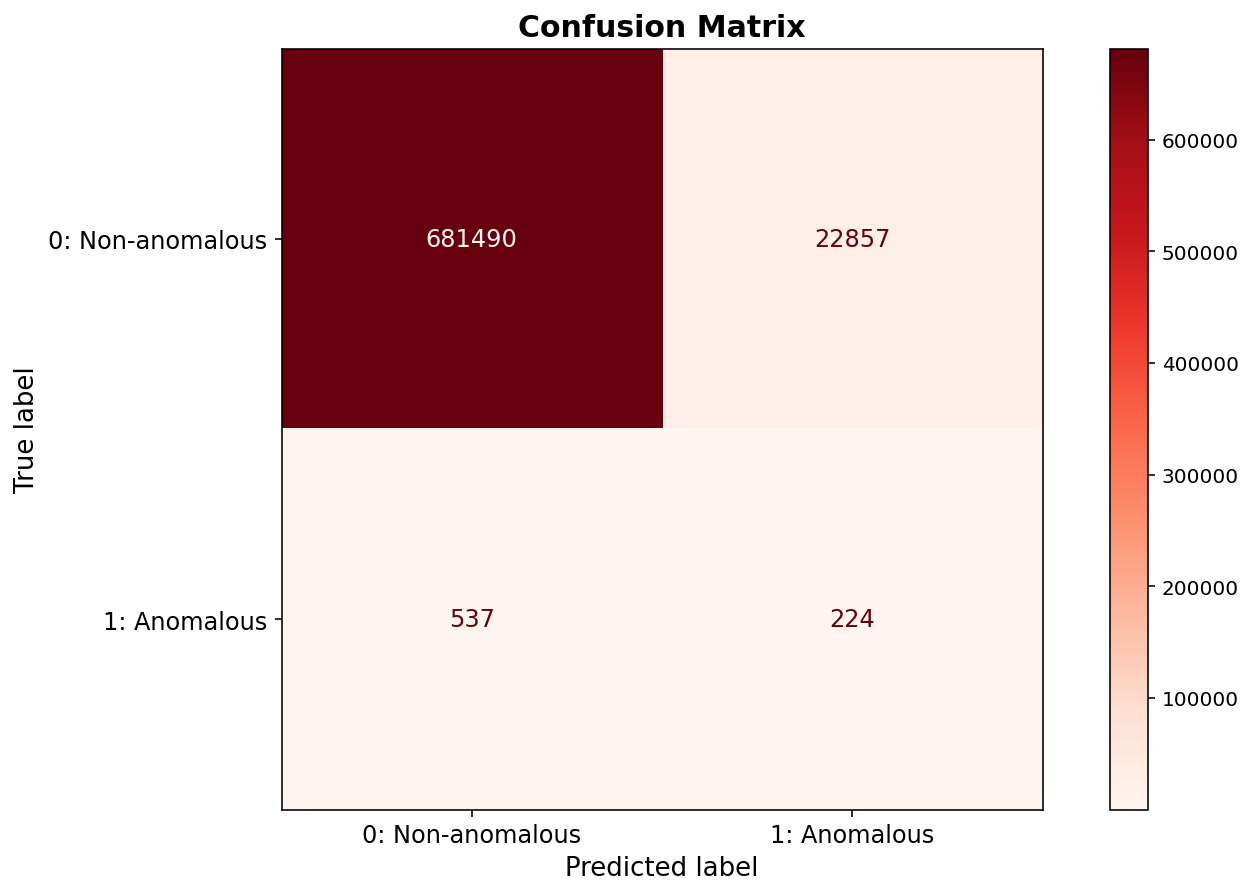

In [162]:
# Plot model confusion matrix
plot_confusion_matrix(model=lr_0_model, test_df=test_df_preprocessed)

**Remarks:**
- With a test set AUPRC of only 0.069, we're not doing too well on the testing data. It looks like we're overfitting to the training data since the AUPRC is significantly better on the training data.

<br>

# Model 1.1: Logistic Regression with Tuned Regularization

For our first tuned `LogisticRegression` model, we'll try to address the overfitting by using regularization.

The `elasticNetParam` parameter specifies the ElasticNet mixing parameter - 0 = L2, while 1 = L1.<br>
The `regParam` parameter specifies the regularization strength.

In [149]:
lr_1 = LogisticRegression(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight',
    standardization=False)

lr_1_stages = stages + [lr_1]

# Specify parameter grid
lr_1_grid = ParamGridBuilder()\
            .addGrid(lr_1.elasticNetParam, [0, 0.25, 0.5, 0.75, 1.0])\
            .addGrid(lr_1.regParam, [0.001, 0.005, 0.01])\
            .build()

In [150]:
# Run grid search
%%time
if not os.path.isdir(drive_path + 'lr_1_model'):
    lr_1_model = grid_search(stages_with_classifier=lr_1_stages, 
                             train_df=train_df_preprocessed, 
                             model_grid=lr_1_grid, 
                             parallelism=15)

{Param(parent='LogisticRegression_04aae7c6886c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.25, Param(parent='LogisticRegression_04aae7c6886c', name='regParam', doc='regularization parameter (>= 0).'): 0.005}
CPU times: user 18.6 s, sys: 3.11 s, total: 21.7 s
Wall time: 17min 58s


In [152]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'lr_1_model'):
    lr_1_model.save(drive_path + 'lr_1_model')
else:
    lr_1_model = TrainValidationSplitModel.load(drive_path + 'lr_1_model')
    print(lr_1_grid[np.argmax(lr_1_model.validationMetrics)])

In [153]:
# Print model scores
score_model(lr_1_model, train_df_preprocessed, test_df_preprocessed)

TrainValidationSplitModel_d56af3e216dd 

Training set accuracy: 0.999	Test set accuracy: 0.999
------------------------------------------------------------
Training set AUPRC: 0.593	Test set AUPRC: 0.577
------------------------------------------------------------
Test set precision
Non-anomalous 0.999	Anomalous: 1.0
------------------------------------------------------------
Test set recall
Non-anomalous: 1.0	Anomalous: 0.152


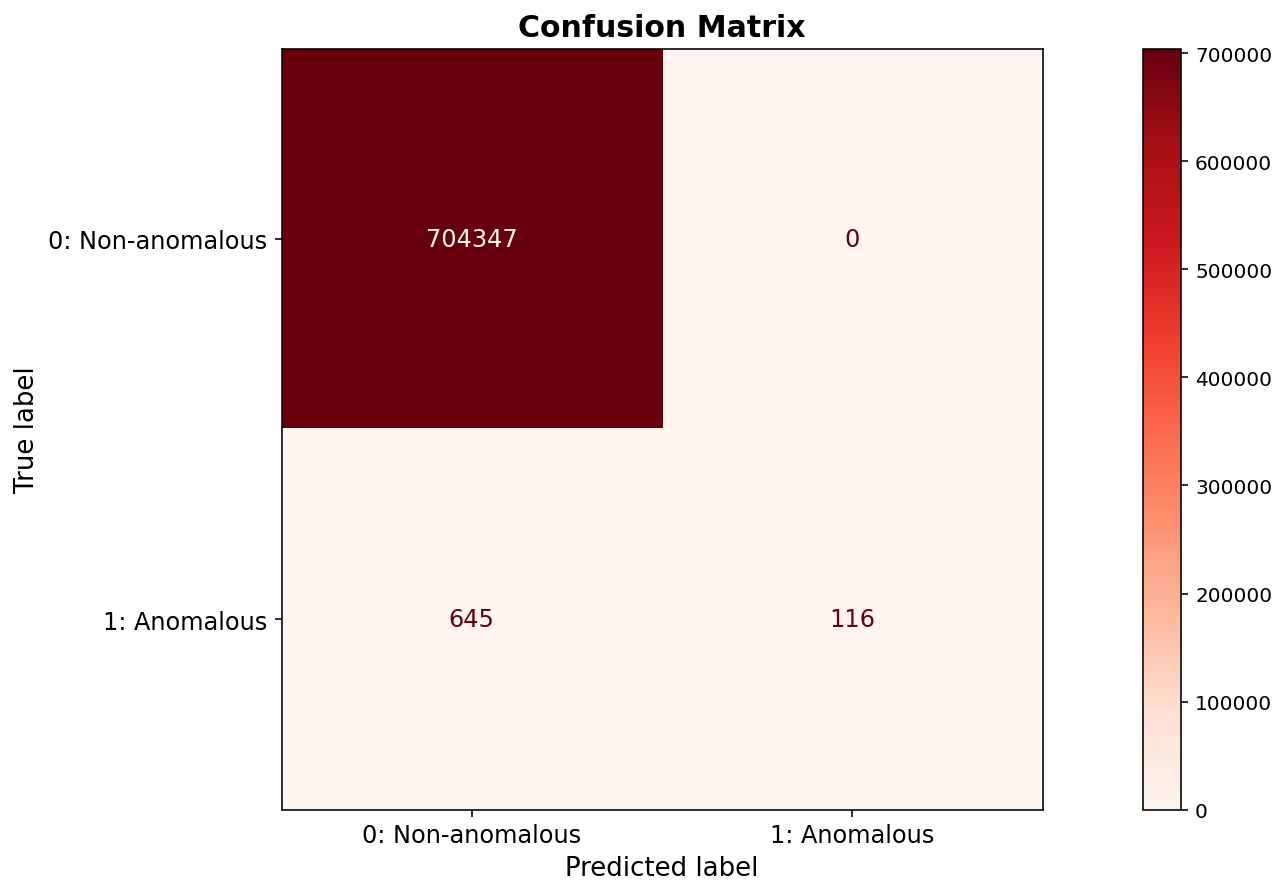

In [196]:
# Plot model confusion matrix
plot_confusion_matrix(lr_1_model, test_df_preprocessed)

**Remarks:**
- Applying regularization improved the model tremendously! We had nearly 23k false positives with the baseline model, and now we don't have a single one. Our test set recall decreased a bit, but for perfect precision I'll take that any day. Our AUPRC is now 0.577.

<br>

# Model 1.2: Logistic Regression with Tuned Threshold

For our next tuned model, we'll attempt to optimize the logistic regression classification threshold. Since we didn't have a single false positive in the last model, we might be able to bring the threshold down without incurring too much of a hit to the false positive rate, resulting in a higher overall AUPRC score.

We'll grid search over the following thresholds: `[0.25, 0.3, 0.35, 0.4, 0.45, 0.5]`

In [229]:
lr_2 = LogisticRegression(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight',
    standardization=False, 
    elasticNetParam=0.25, 
    regParam=0.005)

lr_2_stages = stages + [lr_2]

# Specify parameter grid
lr_2_grid = ParamGridBuilder()\
            .addGrid(lr_2.threshold, list(np.linspace(0.25, 0.5, 6)))\
            .build()

In [230]:
# Run grid search using grid_search function
%%time
if not os.path.isdir(drive_path + 'lr_2_model'):
    lr_2_model = grid_search(stages_with_classifier=lr_2_stages, 
                             train_df=train_df_preprocessed, 
                             model_grid=lr_2_grid, 
                             parallelism=6)

{Param(parent='LogisticRegression_e1940169b460', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.25}
CPU times: user 12.9 s, sys: 2.05 s, total: 14.9 s
Wall time: 9min 56s


In [231]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'lr_2_model'):
    lr_2_model.save(drive_path + 'lr_2_model')
else:
    lr_2_model = TrainValidationSplitModel.load(drive_path + 'lr_2_model')
    print(lr_2_grid[np.argmax(lr_2_model.validationMetrics)])

In [232]:
# Print model scores
score_model(lr_2_model, train_df_preprocessed, test_df_preprocessed)

TrainValidationSplitModel_0e657ccba3ea 

Training set accuracy: 0.999	Test set accuracy: 0.999
------------------------------------------------------------
Training set AUPRC: 0.593	Test set AUPRC: 0.577
------------------------------------------------------------
Test set precision
Non-anomalous 0.999	Anomalous: 1.0
------------------------------------------------------------
Test set recall
Non-anomalous: 1.0	Anomalous: 0.152


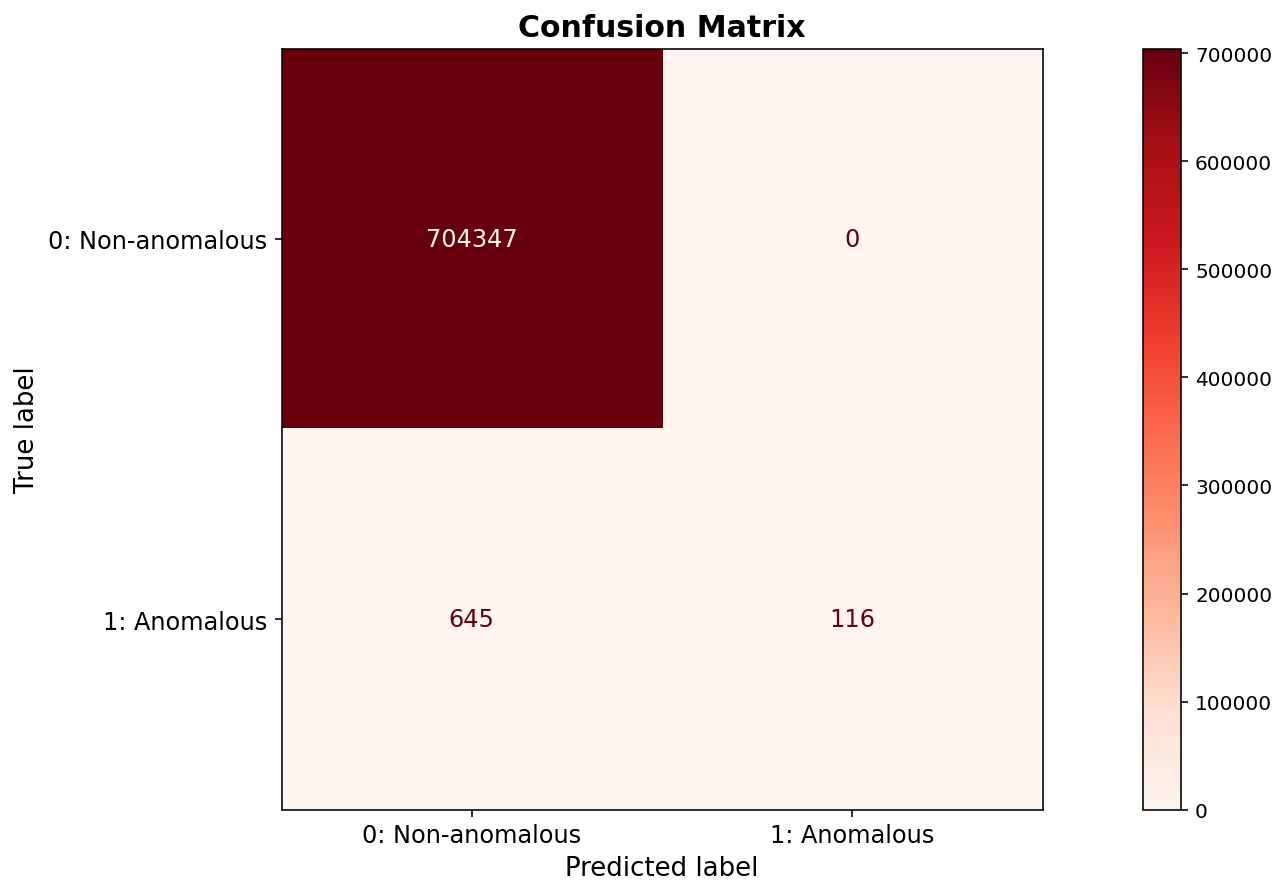

In [233]:
# Plot model confusion matrix
plot_confusion_matrix(lr_2_model, test_df_preprocessed)

**Remarks:**
- Hi